First let's see if the GPU is enabled.

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Let's make sure tensorflow is doign all of it's operations on the GPU, and not the CPU

In [2]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


Great, so now the GPU is working, and should speed up our computations.

In [3]:
#Initialising Hyper Parameters

#Uncomment one of the two below lines. For some reason, on some computers the first one works, while on others the second.
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
import tensorflow as tf

import numpy as np
import keras

np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 100  # input dimension of random vector - the vector that goes into the generator

batch_size = 16   #How many images do we want to include in each batch
steps_per_epoch = 3750  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 10      #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 28, 28, 1

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)


Using TensorFlow backend.


In [4]:
#importing mnist dataset (dataset to mimick), also reshaping the data for preprocessing

#You can import the mnist digit dataset, or the fashion MNIST dataset. For FCGAN, mnist digit works better because it is simpler than the fashion dataset.
from keras.datasets import mnist
#from keras.datasets import fashion_mnist

import os

(x_train, y_train), (x_tet, y_test) = mnist.load_data()     #loading data

x_train = (x_train.astype(np.float32) - 127.5) / 127.5      #Nomralizing the data so that it is from -1 to 1. NNs converge faster this way

x_train = x_train.reshape(-1, img_rows*img_cols*channels)    #The data is in an image style format, so we need to reshape it into a vector.


11493376/11490434 [==============================] - 1s 0us/step


In [ ]:
#Code for plotting results
import matplotlib.pyplot as plt

def show_images(noise, size_fig):
    generated_images = generator.predict(noise)   #Create the images from the GAN.
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

# DCGAN Implementation

In [5]:
#Choose from one of the below datasets
from keras.datasets import fashion_mnist
#from keras.datasets import mnist

import os

(x_train, y_train), (x_tet, y_test) = fashion_mnist.load_data()   #Load the data

x_train = (x_train.astype(np.float32) - 127.5) / 127.5       #Normalize the images again so that the pixel value is from -1 to 1

x_train = x_train.reshape(-1, img_rows, img_cols, channels)  #Reshaping the data into a more NN friendly format

4423680/4422102 [==============================] - 1s 0us/step


Ok, so now we are going to create the generator for the DCGAN. Instead of all of the dense layers, we will be using Conv2D and Conv2D Transpose layers. Also, you can't just add new Conv2D Transpose layers like you can for the FCGAN, since the dimensions would change and the output won't be the same resolution as the image, you would need to reshape the data accordingly.

In [6]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential


def create_generator_cgan():
    generator = Sequential()
    
    d = 7
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))     #We are going to use the same leaky relu activation function as the FCGAN.
    
    generator.add(Reshape((d, d, 256)))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    

    
    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))  #Remember that the final activation has to be tanh, since pixel values go from -1 to 1
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)    #The loss doesn't change when you use convolutional layers
    return generator

Now we are going to make a discriminator. Since we are using convolutional layers, this model is going to look very similar to a standard Convolutional NN. The difference is that instead of classifying the class of the image, we are going to be classifying whether an image is real or fake.

In [7]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

def create_discriminator_cgan():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)  #Again, the loss doesn't change when creating a DCGAN.
    return discriminator

Now that we have changed the generator and discriminator, let's compile them into a single model. This code block is similar to the one used for FCGAN, because they way you join these models (and let the losses flow back) is the same.

In [8]:
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator_cgan()
generator = create_generator_cgan()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job

The fashion MNIST database is more complex than tha standard digit MNIST database. This is because a shoe in the database is very different from a shirt, and these all have complex shapes. Hence, for making the life of the model simpler, I will only be generating T-shirts. The next code block basically limits the training data to only shirts. This makes the model learn to generate images better in fewer epochs (including all classes generates relatively low quality images).

In [9]:
x_train = x_train[np.where(y_train == 0)[0]]

Now, let's just plot a shirt to see how it looks before we train the model and see it's outputs

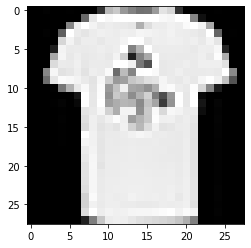

In [12]:
image = x_train[29]
plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')

Again, this code is very similar to the previous one for the FCGAN. This is because the training procedure is also the same. The only fundamental difference is the convolutional layers. This code block takes some time to run. If you use a GPU, it's much faster.
Also, remember that we have already defined the show_images function above. Go back to remind yourself if needed.

Epoch: 1 	 Discriminator Loss: 0.5946675539016724 		 Generator Loss: 1.0773907899856567


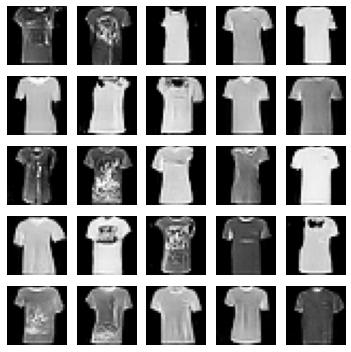

Epoch: 2 	 Discriminator Loss: 0.6128281950950623 		 Generator Loss: 1.2041101455688477


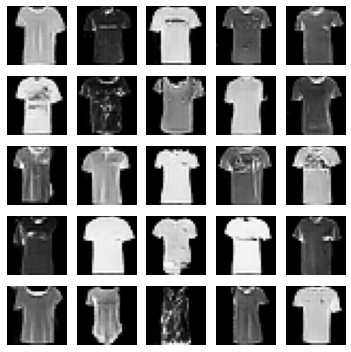

Epoch: 3 	 Discriminator Loss: 0.5287470817565918 		 Generator Loss: 1.5405604839324951


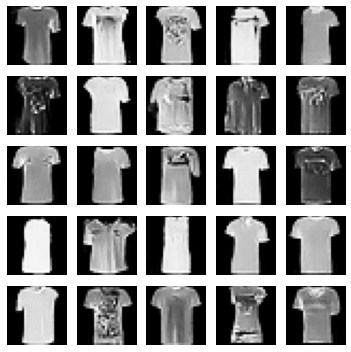

Epoch: 4 	 Discriminator Loss: 0.5735299587249756 		 Generator Loss: 1.6296963691711426


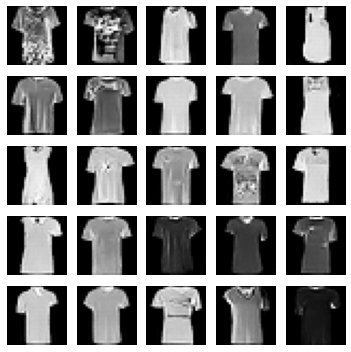

Epoch: 5 	 Discriminator Loss: 0.6892940998077393 		 Generator Loss: 1.0333433151245117


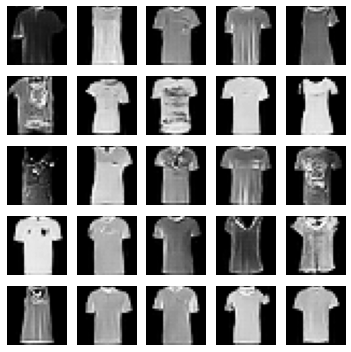

Epoch: 6 	 Discriminator Loss: 0.5004655122756958 		 Generator Loss: 1.3324482440948486


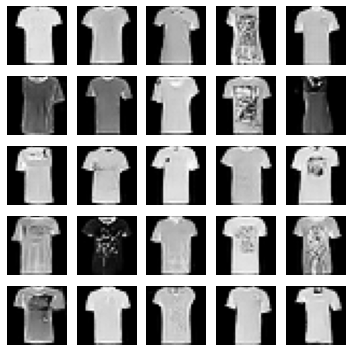

Epoch: 7 	 Discriminator Loss: 0.5009927749633789 		 Generator Loss: 1.3058394193649292


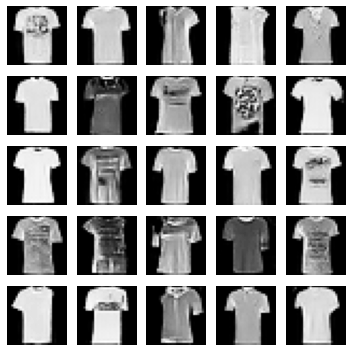

Epoch: 8 	 Discriminator Loss: 0.5410929322242737 		 Generator Loss: 1.875852346420288


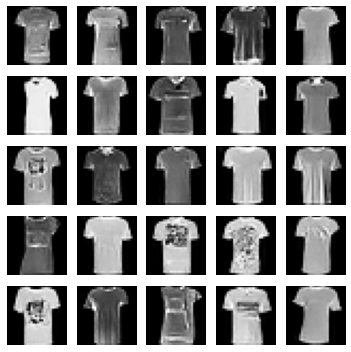

Epoch: 9 	 Discriminator Loss: 0.4930478036403656 		 Generator Loss: 1.374477744102478


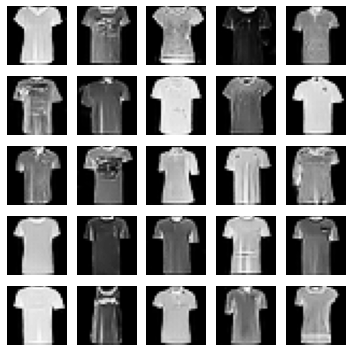

Epoch: 10 	 Discriminator Loss: 0.5885072946548462 		 Generator Loss: 1.7614606618881226


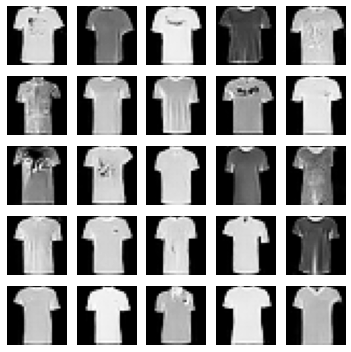

In [14]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        #print(real_x.shape)
        #print(fake_x.shape)
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

Again, we can see that the model is learning quite well over time. Now let's just generate a larger sample of images.

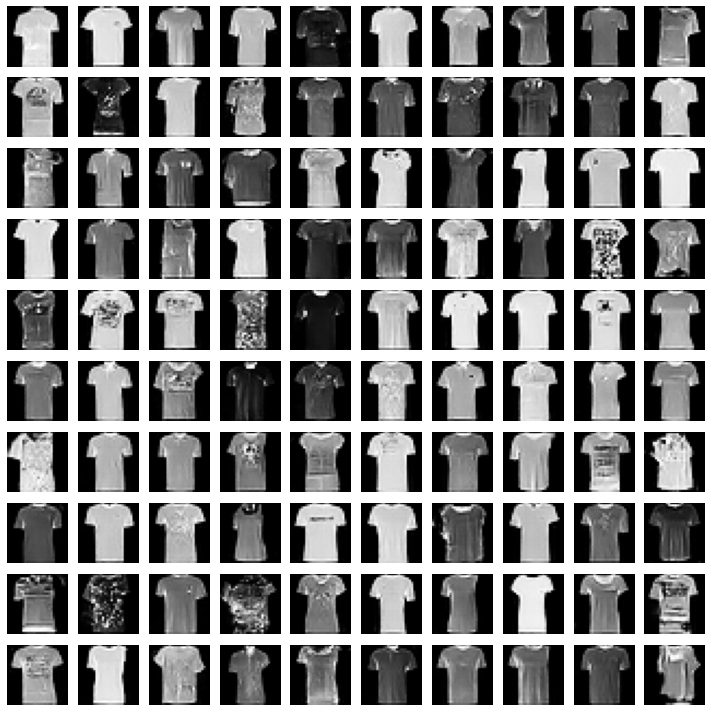

In [15]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise, (10, 10))